In [100]:
import numpy as np
import os, struct
from array import array as pyarray
from numpy import  array, zeros

def load_mnist(dataset="training", digits=np.arange(10), path="."):
    """
    Loads MNIST files into 3D numpy arrays 
    Adapted from: http://abel.ee.ucla.edu/cvxopt/_downloads/mnist.py
    """

    if dataset == "training":
        fname_img = os.path.join(path, 'train-images.idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels.idx1-ubyte')
    elif dataset == "testing":
        fname_img = os.path.join(path, 't10k-images.idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels.idx1-ubyte')
    else:
        raise ValueError("dataset must be 'testing' or 'training'")

    flbl = open(fname_lbl, 'rb')
    magic_nr, size = struct.unpack(">II", flbl.read(8))
    lbl = pyarray("b", flbl.read())
    flbl.close()

    fimg = open(fname_img, 'rb')
    magic_nr, size, rows, cols = struct.unpack(">IIII", fimg.read(16))
    img = pyarray("B", fimg.read())
    fimg.close()

    ind = [ k for k in range(size) if lbl[k] in digits ]
    N = len(ind)

    images = zeros((N, rows, cols) )
    labels = zeros((N ) )
    for i in range(len(ind)):
        images[i] = array(img[ ind[i]*rows*cols : (ind[i]+1)*rows*cols ]).reshape((rows, cols))
        labels[i] = lbl[ind[i]]

    return images, labels
    

In [101]:
# Read in training and test data
X_train, y_train = load_mnist('training') 
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_train = np.divide(X_train, 256)
X_test, y_test = load_mnist('training')
X_test = np.reshape(X_test, (X_test.shape[0], -1)) 
X_test = np.divide(X_test, 256)

(60000, 784)


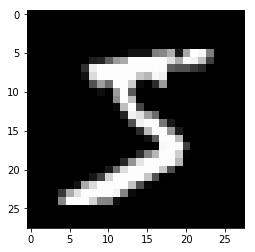

In [102]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.imshow(X_train[0].reshape((28, 28)), cmap="gray")
print(X_train.shape)

In [103]:
def softmax(a):
    #exp = np.exp(a)
    #sum_exp = np.sum(exp)
    #logits = np.divide(exp,sum_exp)
    #return logits
    e_x = np.exp(a)
    return e_x / e_x.sum(axis=0)
    

In [104]:
softmax(X_train)

array([[1.66666667e-05, 1.66666667e-05, 1.66666667e-05, ...,
        1.66666667e-05, 1.66666667e-05, 1.66666667e-05],
       [1.66666667e-05, 1.66666667e-05, 1.66666667e-05, ...,
        1.66666667e-05, 1.66666667e-05, 1.66666667e-05],
       [1.66666667e-05, 1.66666667e-05, 1.66666667e-05, ...,
        1.66666667e-05, 1.66666667e-05, 1.66666667e-05],
       ...,
       [1.66666667e-05, 1.66666667e-05, 1.66666667e-05, ...,
        1.66666667e-05, 1.66666667e-05, 1.66666667e-05],
       [1.66666667e-05, 1.66666667e-05, 1.66666667e-05, ...,
        1.66666667e-05, 1.66666667e-05, 1.66666667e-05],
       [1.66666667e-05, 1.66666667e-05, 1.66666667e-05, ...,
        1.66666667e-05, 1.66666667e-05, 1.66666667e-05]])

In [105]:
# seed random numbers to make calculation
# deterministic (just a good practice)
import numpy as np
np.random.seed(1)

# Starting values for weights W and bias b
#W0 = np.zeros(X_train.shape[1])
b0 = np.zeros(10)
# initialize weights randomly with mean 0
w0 = 2*np.random.random((X_train.shape[1],10)) - 1
#w0 = 2*np.random.random(X_train.shape[1])

In [106]:
w0.shape

(784, 10)

In [107]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y_train)
print(integer_encoded)

[5 0 4 ... 5 6 8]


In [108]:
# binary encode
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)
print(onehot_encoded.shape)
y_train = onehot_encoded

[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
(60000, 10)


In [109]:
def predict(X,W,b):
    return softmax(np.dot(X,W) + b)

In [110]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [111]:
def l2loss(X,y,W,b):
    pred = predict(X, W, b)
    predictions = np.argmax(pred, axis=1)
    l2 = (np.sum(np.square(y - pred)) / 60000)
    gradE_pred = y - pred
    gradE_h = gradE_pred*pred*(1-pred)
    gradE_h = gradE_h.reshape((gradE_h.shape[0],-1))
    gradE_W = np.mean((-2*X)*gradE_h, axis=0)
    gradE_b = np.mean(-2*gradE_h, axis=0)
    return l2, gradE_W, gradE_b



In [112]:
pred = predict(X_train, w0, b0)


In [113]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [93]:
pred

array([[3.75329263e-04, 2.20247627e-05, 4.17364719e-07, ...,
        2.42112119e-09, 8.01392368e-09, 5.89186743e-11],
       [2.93866630e-08, 1.31305828e-08, 1.30488650e-09, ...,
        1.12585335e-07, 1.31338573e-06, 2.19098447e-11],
       [1.15429957e-09, 3.88929898e-09, 1.99732973e-05, ...,
        2.36906835e-10, 3.62855140e-08, 6.97777046e-11],
       ...,
       [1.10207186e-07, 1.78998991e-08, 1.27961075e-09, ...,
        5.60253319e-10, 2.09780553e-09, 7.54013989e-12],
       [5.50925795e-10, 1.83663862e-10, 9.51404467e-06, ...,
        5.02759599e-09, 8.52585827e-05, 1.84886291e-09],
       [2.36677006e-08, 1.33700605e-11, 2.18656151e-09, ...,
        6.44229746e-12, 5.60221061e-12, 1.51767318e-07]])

In [114]:
predictions = np.argmax(pred, axis=1)
predictions

array([0, 3, 2, ..., 3, 6, 3], dtype=int64)

In [115]:
y_train.shape

(60000, 10)

In [122]:
l2 = (np.sum(np.square(y_train - pred)) )
l2/60000

1.8572333333333333

In [123]:
gradE_pred = y_train - pred
gradE_pred.shape

(60000, 10)

In [121]:

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(predictions)
print(integer_encoded)

from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)
print(onehot_encoded.shape)
pred = onehot_encoded


[0 3 2 ... 3 6 3]
[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(60000, 10)


In [124]:
gradE_h = gradE_pred*pred*(1 - pred)
gradE_h

array([[-0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0., -0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [125]:
gradE_h = gradE_h.reshape((gradE_h.shape[0],-1))
gradE_W = np.mean((-2*X_train)*gradE_h, axis=0)
gradE_b = np.mean(-2*gradE_h, axis=0)

ValueError: operands could not be broadcast together with shapes (60000,784) (60000,10) 

In [120]:
gradE_W.shape

(784,)

In [67]:
 w0.shape
    

(784, 10)

In [98]:
%matplotlib inline
from matplotlib import pyplot as plt
def train(X,y,W,b, num_iters=1000, eta=0.001):  
    """
    implement the gradient descent here
    X: N-by-D array of training data 
    y: N dimensional numpy array of labels
    W: D dimensional array of weights
    b: scalar bias
    num_iters: (optional) number of steps to take when optimizing
    eta: (optional)  the stepsize for the gradient descent

    Should return the final values of W and b    
     """
    loss = []
    eta = 1
    for i in range(num_iters):
        l2, gradE_W, gradE_b = l2loss(X, y, W, b)

        W = W - eta*gradE_W 
        b = b - eta*gradE_b

        loss.append(l2)
    plt.plot(range(num_iters), loss)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.show()
    return W, b 



In [85]:
w0.shape

(784, 10)

In [86]:
gradE_W.shape

(784,)

In [99]:
num_iters = 100
eta = 0.001
W,b = train(X_train, y_train, w0, b0, num_iters, eta)

ValueError: operands could not be broadcast together with shapes (60000,10) (60000,) 

In [38]:
yhat = predict(X_test, W, b) 
accuracy = (np.mean(yhat==y_test)*100)


In [43]:
yhat

array([1.55142769e-06, 1.61248063e-06, 3.18397508e-08, ...,
       3.28481639e-07, 9.87610971e-08, 2.00796996e-07])

In [53]:
y_test


array([5., 0., 4., ..., 5., 6., 8.])